In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
import time
from sklearn.metrics import explained_variance_score

In [2]:
class AP_GLM(nn.Module):
    def __init__(self, T_no, device):
        super().__init__()
        
        self.T_no = T_no
        self.device = device
        
        self.kernel = nn.Parameter(torch.randn(self.T_no,2)*0.01)
        #self.kernel2 = nn.Parameter(torch.randn(self.T_no))
        self.bias = nn.Parameter(torch.randn(1))
        self.kernel_hist = nn.Parameter(torch.randn(self.T_no))
        self.step = Step.apply

        """
    def train_forward(self, V, S, temp):
        spk_out = torch.zeros(V.shape[0], V.shape[1] + self.T_no).to(device)
        V_pad = torch.zeros(V.shape[0], V.shape[1]+self.T_no-1, V.shape[2]).to(device)
        V_pad[:,self.T_no-1:,:] = V_pad[:,self.T_no-1:,:] + V
        S_pad = torch.zeros(V.shape[0], V.shape[1]+self.T_no).to(device)
        S_pad[:,self.T_no:] = S_pad[:,self.T_no:] + S
        eps = 1e-10
        
        V_conv1 = F.conv1d(V_pad[:,:,0].unsqueeze(1).clone(), self.kernel1.reshape(1,1,-1)).squeeze(1)
        V_conv2 = F.conv1d(V_pad[:,:,1].unsqueeze(1).clone(), self.kernel2.reshape(1,1,-1)).squeeze(1)
        S_conv = F.conv1d(S_pad.unsqueeze(1).clone(), self.kernel_hist.reshape(1,1,-1)).squeeze(1)[:,:-1].clone()
        binom_in = V_conv1 + V_conv2 + S_conv + self.bias
                
        binom_all = torch.zeros(V.shape[0], V.shape[1], 2).to(device)
        binom_all[:,:,0] = binom_all[:,:,0] + binom_in
        binom_all[:,:,1] = binom_all[:,:,1] + 1 - binom_in
        
        u = torch.rand_like(binom_all)
        g = - torch.log(- torch.log(u + eps) + eps)
        s = F.softmax((binom_all + g)/temp, dim=-1)
        spk_out = s[:,:,0]
        
        return spk_out
        """
            
    def test_forward(self, V, temp):
        #V is shape (batch, 50000, 2)
        
        spk_out = torch.zeros(V.shape[0], V.shape[1] + self.T_no).to(device)
        V_pad = torch.zeros(V.shape[0], V.shape[1]+self.T_no - 1, V.shape[2]).to(device)
        V_pad[:,self.T_no-1:,:] = V_pad[:,self.T_no-1:,:] + V
        eps = 1e-10
        
        for t in range(V.shape[1]):
            spk_hist = spk_out[:,t:t+self.T_no].clone()
            kernel_hist_out = torch.sum(spk_hist * self.kernel_hist.reshape(1,-1), 1)
            kernel_out = torch.sum(V_pad[:,t:t+self.T_no,:] * self.kernel.reshape(1,-1,2) ,[1,2])
            #kernel1_out = torch.sum(self.kernel1.reshape(1,-1) * V_pad[:,t:t+self.T_no,0], 1)
            #kernel2_out = torch.sum(self.kernel2.reshape(1,-1) * V_pad[:,t:t+self.T_no,1], 1)
            binom_in = kernel_out + self.bias + kernel_hist_out
            
            spk = self.step(binom_in)
            
            spk_out[:,t+self.T_no] = spk_out[:,t+self.T_no] + spk
        
        final = spk_out[:,self.T_no:]
        
        return final
    
class Step(torch.autograd.Function):

    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return torch.heaviside(input, torch.ones_like(input))

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        return grad_input * torch.sigmoid(input) * (1 - torch.sigmoid(input))

In [3]:
batch_size = 20
batch_length = int(50000 / 5 / 0.2)
H_no = 40
device = torch.device("cuda")
T_no = 100

epoch_no = 400
iter_no = epoch_no * 980 // batch_size

V = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/data/vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy").reshape(-1,50001)[:,:50000]
#V = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/data/V_diff_stimseed1.npy").reshape(-1,batch_length)
#V = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/na_true_0.1noise1/V_na_true_0.1noise1_0.2ms.npy").reshape(-1,batch_length)
#V = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/diff_true/V_diff_true_0.2ms.npy").reshape(-1,batch_length)
S = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/data/spike_train_0.2ms.npy").reshape(-1,batch_length)

V-= np.mean(V)
V_diff = np.diff(V)

#V = torch.from_numpy(V)
S = torch.from_numpy(S)

V_lag = np.zeros((V.shape[0], V.shape[1], 2)) #(lag,1000,50000)
V_lag[:,:-1,1] = V_diff
V_lag[:,:,0] = V

V_lag = torch.from_numpy(V_lag)
print(V_lag.shape)

torch.Size([1000, 50000, 2])


In [4]:
#V_train = V[:980].float()
#V_test = V[980:].float().to(device)
S_train = S[:980].float()
S_test = S[980:].float().to(device)
V_lag_train = V_lag[:980].float()
V_lag_test = V_lag[980:].float().to(device)

train_idx = np.empty((epoch_no, 980))
for i in range(epoch_no):
    part_idx = np.arange(0,980,1)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.reshape(-1, batch_size)
train_idx = torch.from_numpy(train_idx).long()
print(train_idx.shape)

torch.Size([19600, 20])


In [5]:
model = AP_GLM(T_no, device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0025)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

bce_criterion = nn.BCELoss(reduction="mean")

301


In [ ]:
score_list = []
temp_list = np.logspace(0,-4,100)

#for i in tnrange(iter_no):
for i in tnrange(10000):    
    s = time.time()
    model.train()
    optimizer.zero_grad()
    
    batch_idx = train_idx[i]
    batch_S = S_train[batch_idx].to(device)
    #batch_V = V_train[batch_idx].to(device)
    batch_V_lag = V_lag_train[batch_idx].to(device)
    
    temp = temp_list[i//50]
    
    #batch_V_in = torch.zeros(batch_size, batch_length, lag+1).to(device)
    #batch_V_in[:,:,0] = batch_V
    #batch_V_in[:,:,1:] = batch_V_lag
    batch_V_in = batch_V_lag
    
    S_out = model.test_forward(batch_V_in, temp)
    loss = bce_criterion(S_out, batch_S)
    
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 10)
    optimizer.step()
    
    step_time = time.time() - s
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        #V_test_in = torch.zeros(batch_size, batch_length, lag+1).to(device)
        #V_test_in[:,:,0] = V_test
        #V_test_in[:,:,1:] = V_lag_test
        V_test_in = V_lag_test
        
        test_S_out = model.test_forward(V_test_in, 0.0001)
        test_loss = bce_criterion(test_S_out, S_test).item()
        
        score_list.append(test_loss)
        print(i, test_loss)
        
        tp = np.where((test_S_out.cpu().detach().numpy() == 1) & (S_test.cpu().detach().numpy() == 1))[0].size
        fp = np.where((test_S_out.cpu().detach().numpy() == 1) & (S_test.cpu().detach().numpy() == 0))[0].size
        tn = np.where((test_S_out.cpu().detach().numpy() == 0) & (S_test.cpu().detach().numpy() == 0))[0].size
        fn = np.where((test_S_out.cpu().detach().numpy() == 0) & (S_test.cpu().detach().numpy() == 1))[0].size
        
        print("TP",tp,"FP",fp,"TN",tn,"FN",fn)
        print("-----------------------")

<ipython-input-6-aef03ec96f83>:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(10000):


  0%|          | 0/10000 [00:00<?, ?it/s]

0 0.01979999989271164
TP 0 FP 0 TN 999802 FN 198
-----------------------
49 0.01979999989271164
TP 0 FP 0 TN 999802 FN 198
-----------------------
99 0.01979999989271164
TP 0 FP 0 TN 999802 FN 198
-----------------------
149 0.01979999989271164
TP 0 FP 0 TN 999802 FN 198
-----------------------
199 0.01979999989271164
TP 0 FP 0 TN 999802 FN 198
-----------------------
249 0.01979999989271164
TP 0 FP 0 TN 999802 FN 198
-----------------------
299 0.01979999989271164
TP 0 FP 0 TN 999802 FN 198
-----------------------
349 0.01979999989271164
TP 0 FP 0 TN 999802 FN 198
-----------------------
399 0.01979999989271164
TP 0 FP 0 TN 999802 FN 198
-----------------------


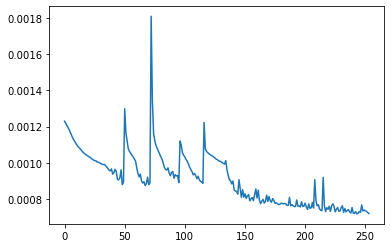

In [7]:
plt.plot(np.asarray(score_list)[20:])

tensor(0.5529, device='cuda:0', grad_fn=<MaxBackward1>)


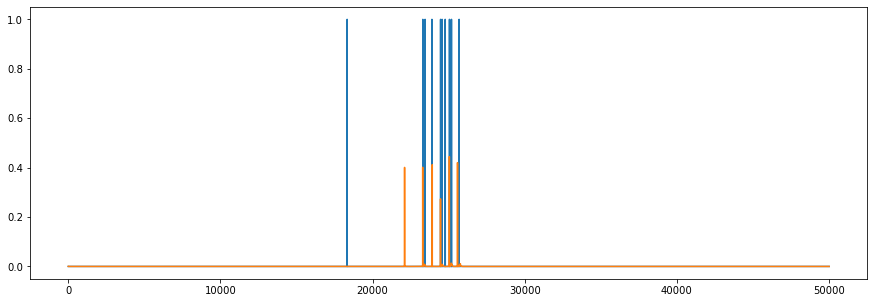

In [8]:
plt.figure(figsize = (15,5))
plt.plot(S_test[0].cpu().detach().numpy())
plt.plot(test_S_out[1].cpu().detach().numpy())
#plt.xlim(4500,5200)
#plt.ylim(-1,10)
print(torch.max(test_S_out))

In [9]:
#torch.save(model.state_dict(), "/media/hdd01/sklee/CA1_clust4-60_AP/na_true_0.1noise1/gru_l20_h40_0.2ms.pt")
#np.save("/media/hdd01/sklee/CA1_clust4-60_AP/na_true_0.1noise1/gru_l20_h40_0.2ms_test.npy", test_S_out.cpu().detach().numpy())